In [6]:
import pandas as pd
import requests
from io import StringIO

url = "https://da.wikipedia.org/wiki/Figurer_fra_Casper_%26_Mandrilaftalen"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
    "AppleWebKit/537.36 (KHTML, like Gecko) "
    "Chrome/116.0.0.0 Safari/537.36"
}
pd.set_option('display.max_rows', None)
response = requests.get(url, headers=headers)

# Read all tables from URL
tables = pd.read_html(StringIO(response.text))

# Pick right table
df = tables[1]

# Flatten multiindex columns into string
# for col in df.columns = loops through each column name
# isinstance(col, tuple) = checks if column is a tuple
# '_'.join(col) = joins tuple into a string ("actor", "name" -> "actor_name")
# else col = if column is a string, leave it alone.
# strip() = removes extra space
df.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col for col in df.columns
]

# Rename columns
rename_table = {
    "Navn_Navn": "navn",
    "Spillet af_Spillet af": "spillet_af",
    "Afsnit_Antal": "antal_afsnit",
    "Afsnit_Numre": "afsnit_nummer",
    "Beskrivelse_Beskrivelse": "beskrivelse",
}

# Convert dtypes
df = df.convert_dtypes()

# Convert table names
df.rename(columns=rename_table, inplace=True)

# removes the [] references
# \[\d+\] Matches any square-bracketed number, like [3], [99]
df[["navn", "beskrivelse"]] = df[["navn", "beskrivelse"]].apply(
    lambda col: col.str.replace(r"\[\d+\]", "", regex=True).str.strip()
)

# Parse and convert "afsnit_nummer" column to lists of integers
df["afsnit_nummer"] = (
    # Column as string
    df["afsnit_nummer"]
    # Ensure all values are strings
    .astype(str)
    # Split each string by comma = ["32", "41"]
    .str.split(",").apply(
        # For each list of strings:
        lambda lst: [
            # For each part, handle ranges and single numbers
            int(x)  # Converts each ep nr (range or list) to an Int
            for part in lst  # Iterates over each comma-seperated segment ('1-3', '47')
            for x in (  # Allows handling both ranges (range(...)) and single values ([value])
                # Handle ranges like "1-67"
                range(
                    int(part.split("-")[0]), int(part.split("-")[1]) + 1
                )  # Expands ranges like '1-3' into '1, 2, 3'
                if "-" in part
                and part.split("-")[0].isdigit()  # Make sure part is number
                and part.split("-")[1].isdigit()
                else [
                    part.strip()
                ]  # Handles single ep number by putting in one-element list
            )
            # Only convert to int if it’s a digit
            if (str(x).isdigit())  # Final check to make sure it's converted to numeric
        ]
    )
)


# Explode list
# Takes each list in column and creates one row per element in the list
# .reset_index[drop=True] resets index to be clean and sequential after explosion
df = df.explode("afsnit_nummer").reset_index(drop=True)
# Converts column from object to nullable integer dtype(Int64)
df["afsnit_nummer"] = df["afsnit_nummer"].astype("Int64")
# Explode outputs generic types!

In [12]:
df.dtypes

navn             string[python]
spillet_af       string[python]
antal_afsnit              Int64
afsnit_nummer             Int64
beskrivelse      string[python]
dtype: object

In [11]:
df

,navn,spillet_af,antal_afsnit,afsnit_nummer,beskrivelse
0,Abraham Mamrelund,Sebastian Dorset,1,41,Starfucker.
1,Adolf Honningånde og Kuntakinte Eriksen,Lars Hjortshøj og Lasse Rimmer,1,61,To genstridige naboer.
2,Alf Bat,Lasse Rimmer,1,11,Kedelbruger med hang til hyng.
3,Alfonso Trendy,Frank Hvam,2,36,"Har glemt, hvorfor han er kommet i studiet. Tr..."
4,Alfonso Trendy,Frank Hvam,2,41,"Har glemt, hvorfor han er kommet i studiet. Tr..."
5,Alfred Balle,Frank Hvam,2,64,"Pædagog, dyrepsykolog og forfatter til lydboge..."
6,Alfred Balle,Frank Hvam,2,66,"Pædagog, dyrepsykolog og forfatter til lydboge..."
7,Ali Baba,Lars Hjortshøj,1,5,Lektor ved Københavns Hovedbanegård. Da Casper...
8,Amant Krill,Lasse Rimmer,1,13,Ekspert i sommertid.
9,Anne Linnet,Lars Hjortshøj,1,64,Sangerinde og komponist på turné.


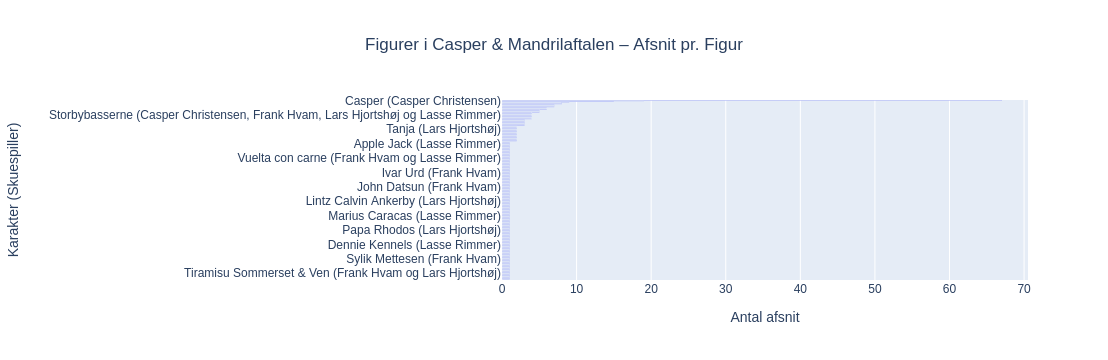

In [19]:
import plotly.express as px

# Group data
grouped = (
    df.groupby(["navn", "spillet_af"])
    .agg(
        antal_afsnit=("afsnit_nummer", "nunique"),
        afsnit_liste=("afsnit_nummer", lambda x: sorted(set(x.dropna())))
    )
    .reset_index()
)

# Optional: Combine 'navn' and 'spillet_af' into one label for display
grouped["figur_label"] = grouped["navn"] + " (" + grouped["spillet_af"] + ")"

# Create Plotly bar chart
fig = px.bar(
    grouped.sort_values("antal_afsnit", ascending=False),
    x="antal_afsnit",
    y="figur_label",
    orientation="h",
    hover_data={
        "antal_afsnit": True,
        "afsnit_liste": True,
        "figur_label": False  # Avoid duplicate info in hover
    },
    labels={
        "antal_afsnit": "Antal afsnit",
        "figur_label": "Karakter (Skuespiller)"
    },
    title="Figurer i Casper & Mandrilaftalen – Afsnit pr. Figur"
)

# Update layout for better spacing
fig.update_layout(
    yaxis=dict(autorange="reversed"),  # So top character is at the top
    title_x=0.5
)

fig.show()
